Pré-processamento dos Dados

In [ ]:
#Importação de Bibliotecas
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import re
from collections import Counter

#Carregando e exibindo a base de dados
df = pd.read_csv("teste_indicium_precificacao.csv")
print(df.head())

     id                                              nome  host_id  \
0  2595                             Skylit Midtown Castle     2845   
1  3647               THE VILLAGE OF HARLEM....NEW YORK !     4632   
2  3831                   Cozy Entire Floor of Brownstone     4869   
3  5022  Entire Apt: Spacious Studio/Loft by central park     7192   
4  5099         Large Cozy 1 BR Apartment In Midtown East     7322   

     host_name bairro_group        bairro  latitude  longitude  \
0     Jennifer    Manhattan       Midtown  40.75362  -73.98377   
1    Elisabeth    Manhattan        Harlem  40.80902  -73.94190   
2  LisaRoxanne     Brooklyn  Clinton Hill  40.68514  -73.95976   
3        Laura    Manhattan   East Harlem  40.79851  -73.94399   
4        Chris    Manhattan   Murray Hill  40.74767  -73.97500   

         room_type  price  minimo_noites  numero_de_reviews ultima_review  \
0  Entire home/apt    225              1                 45    2019-05-21   
1     Private room    150   

In [177]:
#Aponta a quantidade de valores faltantes em cada coluna
print("Valores ausentes por coluna:\n",df.isna().sum())

Valores ausentes por coluna:
 id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


In [178]:
#Limpeza dos Dados removendo linhas (NaN) da coluna 'nome'
df.dropna(subset=['nome'], inplace=True)
print(df.isna().sum())

id                                   0
nome                                 0
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10042
reviews_por_mes                  10042
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


In [179]:
#Criando identificação para anfitrião usando seu 'host_id' como referência
df['host_id'] = df['host_id'].fillna(-1).astype(int)
df['host_name'] = df['host_name'].fillna("Anfitrião_" + df['host_id'].astype(str))

In [180]:
#Conta valores ausentes (NaN) nas colunas 'ultima_review' e 'reviews_por_mes' Exibe estatísticas descritivas de 'numero_de_reviews' (média, min, max...)
print(df['ultima_review'].isna().sum())  
print(df['reviews_por_mes'].isna().sum()) 
print(df['numero_de_reviews'].describe())  # Estatísticas sobre a coluna

10042
10042
count    48878.000000
mean        23.281497
std         44.556558
min          0.000000
25%          1.000000
50%          5.000000
75%         24.000000
max        629.000000
Name: numero_de_reviews, dtype: float64


In [181]:
#Tratando dados temporais e convertendo a coluna de 'ultima_review' para formato datetime
df['ultima_review'] = pd.to_datetime(df['ultima_review'], errors='coerce')
df['ultima_review'] = df.groupby('host_id')['ultima_review'].transform('max')
df['ultima_review'].fillna(pd.Timestamp("2000-01-01"), inplace=True)  # Define um valor padrão

C:\Users\allys\AppData\Local\Temp\ipykernel_12680\2769197053.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['ultima_review'].fillna(pd.Timestamp("2000-01-01"), inplace=True)  # Define um valor padrão


In [182]:
#Preenchendo valores (NaN) com '0'

df['ultima_review'] = df['ultima_review'].fillna(0)
df['reviews_por_mes'] = df['reviews_por_mes'].fillna(0)

In [203]:
#Conversão e limpeza de dados de Preço

print(df['price'].unique())
df['price'] = df['price'].astype(str).str.replace('[^.]', '', regex=True)  # Remove caracteres não numéricos
df['price'] = pd.to_numeric(df['price'], errors='coerce')  # Converte para número
df.dropna(subset=['price'], inplace=True)
df['price'] = df['price'].astype(float)

[]


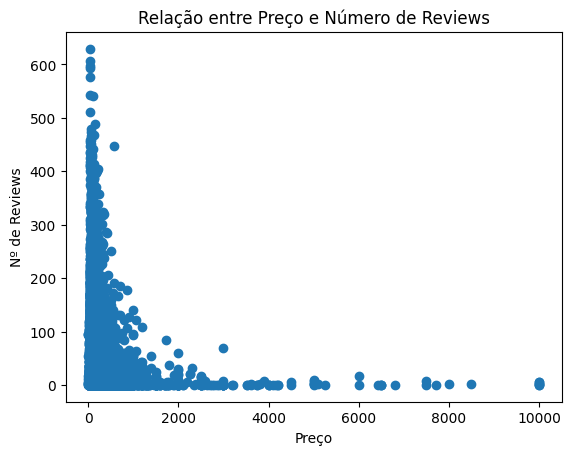

In [184]:
#Análise visual

df = df.dropna(subset=['price', 'numero_de_reviews'])
plt.scatter(df['price'], df['numero_de_reviews'])
plt.xlabel('Preço')
plt.ylabel('Nº de Reviews')
plt.title('Relação entre Preço e Número de Reviews')
plt.show()

In [185]:
media_prices = df.groupby('bairro_group')['price'].mean().round(2).sort_values()
print("Média de preços por bairro_group:")
print(media_prices)

Média de preços por bairro_group:
bairro_group
Bronx             87.46
Queens            99.52
Staten Island    114.81
Brooklyn         124.39
Manhattan        196.88
Name: price, dtype: float64


In [186]:
#Verificando padrões no texto do nome do local para lugares de mais alto valor
limite_preco = df['price'].quantile(0.90)
locais_mais_caros = df[df['price'] >= limite_preco]
#Concatenar os nomes e separar palavras, removendo caracteres especiais
todos_nomes = " ".join(locais_mais_caros['nome']).lower()
palavras = re.findall(r'\b[a-zA-Z]+\b', todos_nomes)
#Contar frequência das palavras
contagem_palavras = Counter(palavras)
#Exibir as 10 palavras mais comuns
print("Palavras mais comuns em locais mais caros:")
print(contagem_palavras.most_common(10))



Palavras mais comuns em locais mais caros:
[('in', 1208), ('bedroom', 725), ('apartment', 558), ('apt', 515), ('luxury', 478), ('loft', 467), ('w', 443), ('the', 408), ('village', 385), ('park', 372)]


In [187]:
def sugerir_preco(apartamento):
    modelo = joblib.load("modelo_precificacao.pkl")
    colunas = ['latitude', 'longitude', 'room_type', 'minimo_noites', 'numero_de_reviews',
    'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']
    entrada = pd.DataFrame([apartamento], columns=colunas)
    preco_sugerido = modelo.predict(entrada)
    return preco_sugerido[0]

TREINAMENTO DE MODELO

In [188]:
#Verifica se a coluna 'room_type' existe no DataFrame
if 'room_type' not in df.columns:
    raise KeyError("A coluna 'room_type' não existe no DataFrame!")

#Preencher valores NaN com um valor padrão
df['room_type'] = df['room_type'].fillna("Desconhecido")

#Remover espaços extras para evitar problemas com valores inconsistentes
df['room_type'] = df['room_type'].str.strip()

#Criar variáveis dummy corretamente
variaveis = ['latitude', 'longitude', 'room_type', 'minimo_noites', 'numero_de_reviews',
             'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']

x = pd.get_dummies(df[variaveis], drop_first=True)
y = df['price']


In [189]:
#Divisão entre treino e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, random_state=42)


In [190]:
#Treinando o modelo
modelo = RandomForestRegressor(random_state=42)
modelo.fit(x_treino, y_treino)

RandomForestRegressor(random_state=42)

In [191]:
#Avaliação do modelo
predicoes = modelo.predict(x_teste)
print("Métricas de Avaliação:")
print("Mean Absolute Error:", mean_absolute_error(y_teste, predicoes))
print("Mean Squared Error:", mean_squared_error(y_teste, predicoes))
print("R2 Score:", r2_score(y_teste, predicoes))

Métricas de Avaliação:
Mean Absolute Error: 66.21212970540098
Mean Squared Error: 39889.41076331833
R2 Score: 0.12458431777494139


In [192]:
#Salvando dados do modelo

joblib.dump(modelo, "modelo_precificacao.pkl")

['modelo_precificacao.pkl']

In [193]:
#1- Investimento ideal

local_ideal = media_prices.idxmax()
print(f"O melhor bairro para investimento é {local_ideal}, com média de preço de {media_prices[local_ideal]:.2f}.")

O melhor bairro para investimento é Manhattan, com média de preço de 196.88.


In [194]:
#2- Influência de noites mínimas e disponibilidade no preço

correlacao_minimo_noites = df['price'].corr(df['minimo_noites'])
correlacao_disponibilidade = df['price'].corr(df['disponibilidade_365'])
print(f"Correlação entre preço e noites mínimas: {correlacao_minimo_noites:.2f}.")
print(f"Correlação entre preço e disponibilidade: {correlacao_disponibilidade:.2f}.")

Correlação entre preço e noites mínimas: 0.04.
Correlação entre preço e disponibilidade: 0.08.


In [195]:
#3- Padrões no nome do local

df['nome_length'] = df['nome'].str.len()
correlacao_nome_valor = df['price'].corr(df['nome_length'])
print(f"Correlação entre tamanho do nome e preço: {correlacao_nome_valor:.2f}.")



Correlação entre tamanho do nome e preço: 0.04.


In [196]:
#Carregando o modelo treinado anteriormente 
modelo = joblib.load("modelo_precificacao.pkl")

In [197]:
def sugerir_preco(apartamento):
    modelo = joblib.load("modelo_precificacao.pkl")

    # Pegamos as features exatas usadas no modelo treinado
    colunas = modelo.feature_names_in_

    # Criamos um DataFrame preenchido com zeros
    entrada = pd.DataFrame(0, index=[0], columns=colunas)

    # Preenchendo os valores numéricos
    for col in ['latitude', 'longitude', 'minimo_noites', 'numero_de_reviews', 
                'reviews_por_mes', 'calculado_host_listings_count', 'disponibilidade_365']:
        if col in entrada.columns:
            entrada[col] = apartamento[col]

    # Ajustando o tipo de quarto (one-hot encoding correto)
    room_type_col = f"room_type_{apartamento['room_type']}"
    if room_type_col in entrada.columns:
        entrada.loc[0, room_type_col] = 1

    # Fazer a previsão
    preco_sugerido = modelo.predict(entrada)
    return preco_sugerido[0]


In [198]:
modelo = joblib.load("modelo_precificacao.pkl")
print(modelo.feature_names_in_)

['latitude' 'longitude' 'minimo_noites' 'numero_de_reviews'
 'reviews_por_mes' 'calculado_host_listings_count' 'disponibilidade_365'
 'room_type_Private room' 'room_type_Shared room']


In [199]:
modelo = joblib.load("modelo_precificacao.pkl")
print(modelo.feature_names_in_)


['latitude' 'longitude' 'minimo_noites' 'numero_de_reviews'
 'reviews_por_mes' 'calculado_host_listings_count' 'disponibilidade_365'
 'room_type_Private room' 'room_type_Shared room']


In [200]:
apartamento = {
    'latitude': 40.75362,
    'longitude': -73.98377,
    'room_type': 'Entire home/apt',
    'minimo_noites': 1,
    'numero_de_reviews': 45,
    'reviews_por_mes': 0.38,
    'calculado_host_listings_count': 2,
    'disponibilidade_365': 355
}

sugestao_preco = sugerir_preco(apartamento)
print(f"Sugestão de preço para o apartamento especificado: {sugestao_preco:.2f}.")


Sugestão de preço para o apartamento especificado: 298.73.
